In [1]:
%matplotlib inline

import sys
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as st
from multiprocessing import Pool

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', 500)


In [2]:
# Read in average personal finance data
pf = pd.read_csv('average_personal_income_and_expense.csv', index_col=0, parse_dates=True)
pf.dropna(axis=1, inplace=True)


In [3]:
# Sample onto daily timeframe
daily_pf = pf.resample('D', how='mean').interpolate(method='polynomial', order=5, limit_direction='both')


In [4]:
# Get the % change from data
daily_pf_change = daily_pf.pct_change()
daily_pf_change = daily_pf_change.iloc[1:]
daily_pf_change = daily_pf_change.replace([np.inf, -np.inf], 1)


In [3]:
# Create models from data
def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, normed=True)
    x = [(a+x[i+1])/2.0 for i,a in enumerate(x[0:-1])]

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,st.dgamma,
        st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,st.foldcauchy,
        st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,st.genextreme,st.gausshyper,
        st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,st.gumbel_l,st.halfcauchy,st.halflogistic,
        st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,
        st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,
        st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,
        st.powernorm,st.rdist,st.reciprocal,st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,
        st.truncnorm,st.tukeylambda,st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                # Fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def par_dist_fit(x):
    col, data = x
    model, params = best_fit_distribution(data)
    return (col, model, params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


In [39]:

models = {}
pool = Pool()
col_data = [(col, data) for col, data in daily_pf_change.iteritems()]
fit_models = pool.map(par_dist_fit, col_data)
pool.close()
pool.join()


In [104]:
# Create random % changes for future
number_of_days_to_sim = 10*365
date_range = pd.date_range(start='2015-01-01', freq='D', periods=number_of_days_to_sim)
rand_pf = pd.DataFrame(None, columns=pf.columns, index=date_range)

for col, model_name, params in fit_models:
    # Get the model
    model = getattr(st, model_name)
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    
    rvs = model(loc=loc,scale=scale, *arg).rvs(size=number_of_days_to_sim)
    rand_pf[col] = rvs


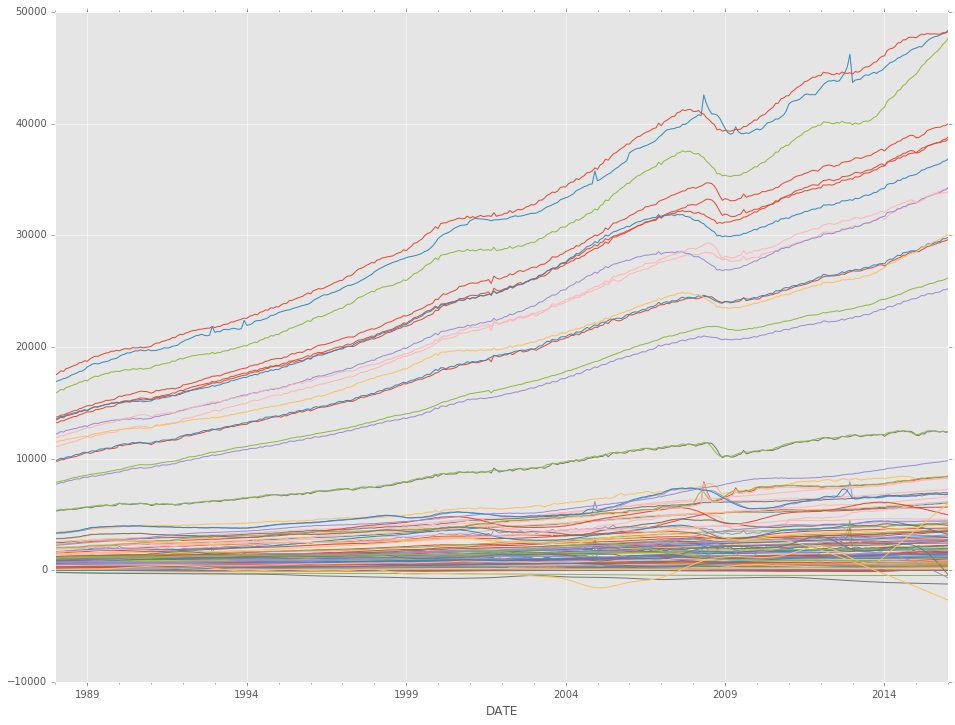

In [108]:
pf.plot(legend=False)

In [1]:
size = 10*365

i = daily_pf.index.get_loc('2015-01-01')
ax = daily_pf.iloc[i-2*size:i].plot(legend=False, color='r', alpha=0.25, logy=True)
(1 + rand_pf.cumsum()).multiply(daily_pf.iloc[i]).iloc[:size].plot(legend=False, color='b', alpha=0.25, logy=True, ax=ax)


In [2]:
for col, model_name, params in fit_models:
    model = getattr(st, model_name)

    plt.figure(figsize=(12,6))
    ax = make_pdf(model, params).plot(label='Model', legend=True)
    daily_pf_change[col].dropna().plot(kind='hist', bins=200,  alpha=0.7, normed=True, label='historical', legend=True, ax=ax)
    rand_pf[col].dropna().plot(kind='hist', bins=100, color='k', alpha=0.3, normed=True, label='projected', legend=True, ax=ax)

    ax.set_title('{}\n{}({})'.format(col, model_name, ', '.join(['{:0.4f}'.format(x) for x in params])))
